# Introduction

#### Project ini bertujuan untuk memenuhi tugas akhir mata kuliah Deep Learning dengan mengembangkan sistem klasifikasi buah sehat vs busuk menggunakan metode Convolutional Neural Network (CNN).

## Install Library yang digunakan

In [30]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
import time

## Path Direktori Dataset

In [31]:
train_dir = "/kaggle/input/dataset-fruit-healthy-vs-rotten/train/"
val_dir = "/kaggle/input/dataset-fruit-healthy-vs-rotten/val/"
test_dir = "/kaggle/input/dataset-fruit-healthy-vs-rotten/test/"

## Inisiasi Parameter Awal

In [32]:
img_height=224
img_width=224
epoch = 10
batch_size = 32
learning_rate = 0.0001

## Data Augmentation

- `rescale=1./255`: Mengurangi nilai piksel gambar menjadi rentang [0, 1] untuk normalisasi.
- `rotation_range=20`: Memutar gambar secara acak dalam rentang 20 derajat.
- `width_shift_range=0.2`: Menggeser gambar secara horizontal hingga 20% dari lebar gambar.
- `height_shift_range=0.2`: Menggeser gambar secara vertikal hingga 20% dari tinggi gambar.
- `shear_range=0.2`: Melakukan distorsi gambar secara acak dengan faktor geser.
- `zoom_range=0.2`: Memperbesar atau memperkecil gambar secara acak.
- `horizontal_flip=True`: Membalik gambar secara horizontal secara acak.

In [33]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

## Data Generator

In [34]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 6644 images belonging to 2 classes.
Found 1426 images belonging to 2 classes.
Found 1423 images belonging to 2 classes.


## Menampilkan Gambar untuk Setiap kelas

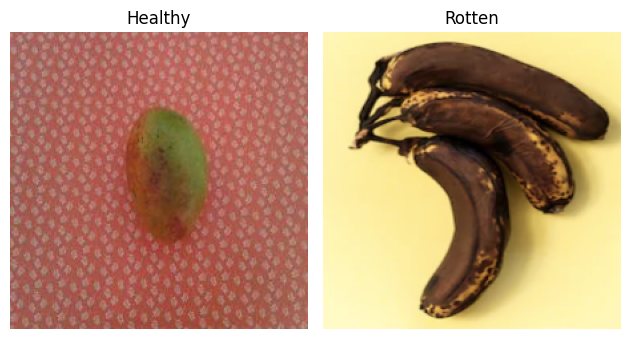

In [35]:
class_names = list(train_generator.class_indices.keys())

# Menampilkan satu gambar dari setiap kelas yang di-resize ke 224x224
for i, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    image_name = os.listdir(class_path)[0]  # Mengambil gambar awal
    image_path = os.path.join(class_path, image_name)
    
    # Mengubah gambar ke 224x224
    img = mpimg.imread(image_path)
    img_resized = cv2.resize(img, (224, 224))
    
    # Menampilkan gambar
    plt.subplot(1, len(class_names), i + 1)
    plt.imshow(img_resized)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Loading Pre-trained Xception Model and Freezing Layers

In [36]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

for layer in base_model.layers:
    layer.trainable = False
        
for layer in base_model.layers: 
    print(f'{layer.name}: {layer.trainable}')

input_layer_4: False
block1_conv1: False
block1_conv1_bn: False
block1_conv1_act: False
block1_conv2: False
block1_conv2_bn: False
block1_conv2_act: False
block2_sepconv1: False
block2_sepconv1_bn: False
block2_sepconv2_act: False
block2_sepconv2: False
block2_sepconv2_bn: False
conv2d_8: False
block2_pool: False
batch_normalization_8: False
add_24: False
block3_sepconv1_act: False
block3_sepconv1: False
block3_sepconv1_bn: False
block3_sepconv2_act: False
block3_sepconv2: False
block3_sepconv2_bn: False
conv2d_9: False
block3_pool: False
batch_normalization_9: False
add_25: False
block4_sepconv1_act: False
block4_sepconv1: False
block4_sepconv1_bn: False
block4_sepconv2_act: False
block4_sepconv2: False
block4_sepconv2_bn: False
conv2d_10: False
block4_pool: False
batch_normalization_10: False
add_26: False
block5_sepconv1_act: False
block5_sepconv1: False
block5_sepconv1_bn: False
block5_sepconv2_act: False
block5_sepconv2: False
block5_sepconv2_bn: False
block5_sepconv3_act: False
b

## Building and Compiling the Sequential Model

In [37]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])
        
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
model.build((None, img_height, img_width, 3))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,243,242 (275.59 MB)

 Trainable params: 51,381,762 (196.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

## Training and Saving the Model

In [38]:
history = model.fit(
    train_generator,
    epochs=epoch,
    validation_data=val_generator,
    verbose=1
)

model.save(f'Model_{learning_rate}_{batch_size}.h5')

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 50/208 ━━━━━━━━━━━━━━━━━━━━ 1:26 546ms/step - accuracy: 0.6325 - loss: 1.8056

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


208/208 ━━━━━━━━━━━━━━━━━━━━ 140s 617ms/step - accuracy: 0.7385 - loss: 0.9599 - val_accuracy: 0.8976 - val_loss: 0.2594
Epoch 2/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 127s 592ms/step - accuracy: 0.8767 - loss: 0.2938 - val_accuracy: 0.9095 - val_loss: 0.2185
Epoch 3/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 130s 606ms/step - accuracy: 0.9025 - loss: 0.2430 - val_accuracy: 0.9194 - val_loss: 0.1960
Epoch 4/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 128s 595ms/step - accuracy: 0.9056 - loss: 0.2265 - val_accuracy: 0.9278 - val_loss: 0.1819
Epoch 5/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 127s 590ms/step - accuracy: 0.9156 - loss: 0.2153 - val_accuracy: 0.9362 - val_loss: 0.1721
Epoch 6/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 127s 594ms/step - accuracy: 0.9188 - loss: 0.1962 - val_accuracy: 0.9299 - val_loss: 0.1857
Epoch 7/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 128s 596ms/step - accuracy: 0.9213 - loss: 0.1902 - val_accuracy: 0.9299 - val_loss: 0.1750
Epoch 8/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 128s 597ms/step - accuracy: 0.9273 - loss: 0.18

## Model Evaluation and Classification Report

In [39]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Assuming you have already made predictions with the model
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Set output_dict=True to get the classification report as a dictionary
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Output the report
print(report)

45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 350ms/step
              precision    recall  f1-score   support

     Healthy       0.94      0.95      0.95       711
      Rotten       0.95      0.94      0.95       712

    accuracy                           0.95      1423
   macro avg       0.95      0.95      0.95      1423
weighted avg       0.95      0.95      0.95      1423



## Visualizing Model Performance

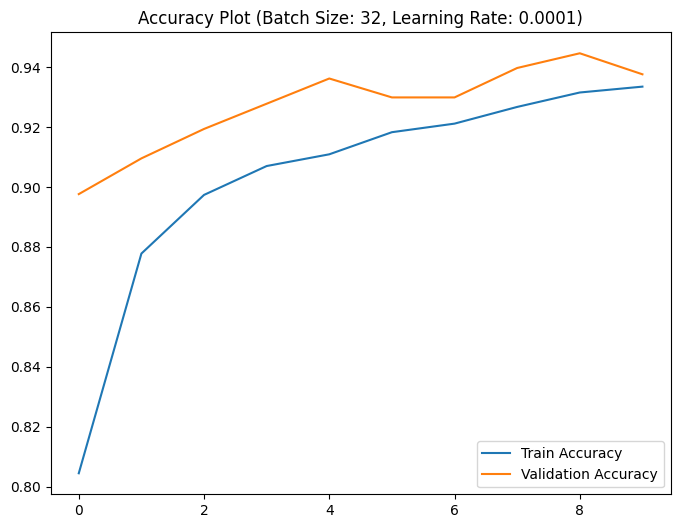

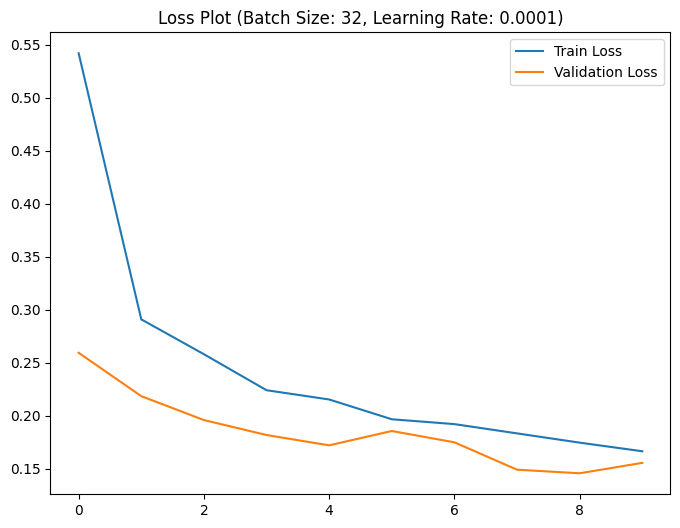

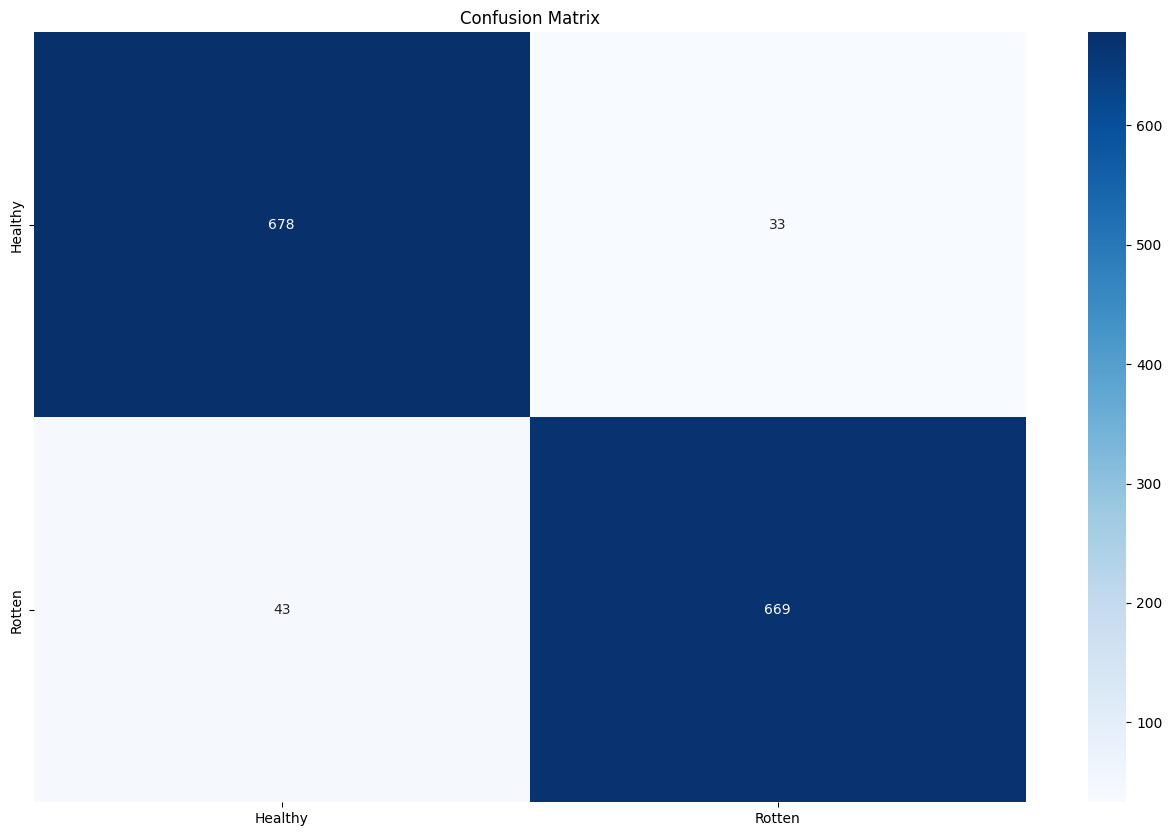

In [40]:
epochs_range = range(len(history.history['accuracy']))

# Accuracy plot
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(f'Accuracy Plot (Batch Size: {batch_size}, Learning Rate: {learning_rate})')
plt.savefig(f'Xception_FREEZE_accuracy_{batch_size}_{learning_rate}.png')
plt.show()

# Loss plot
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, history.history['loss'], label='Train Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title(f'Loss Plot (Batch Size: {batch_size}, Learning Rate: {learning_rate})')
plt.savefig(f'Xception_FREEZE_loss_{batch_size}_{learning_rate}.png')
plt.show()

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(16, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.savefig(f'Xception_FREEZE_confusion_matrix_{batch_size}_{learning_rate}.png')
plt.show()

In [41]:
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)

report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
precision = np.mean([report[label]['precision'] for label in class_labels])
recall = np.mean([report[label]['recall'] for label in class_labels])
f1_score = np.mean([report[label]['f1-score'] for label in class_labels])

## Storing Training Results in a DataFrame

In [42]:
results = []

results.append({
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "train_accuracy": train_accuracy,
    "val_accuracy": val_accuracy,
    "test_accuracy": test_accuracy,
    "train_loss": train_loss,
    "val_loss": val_loss,
    "test_loss": test_loss,
    "precision": precision,
    "recall": recall,
    "f1_score": f1_score,
})

results_df = pd.DataFrame(results)
results_df.to_csv(f'Xception_{batch_size}_{learning_rate}')
results_df

,batch_size,learning_rate,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,test_loss,precision,recall,f1_score
0,32,0.0001,0.933474,0.937588,0.946592,0.166551,0.155612,0.130119,0.946676,0.946597,0.94659
